# Detecting Switches  
> This module provides tools to identify potential isoform switches within single-cell isoform-resolution datasets. It includes methods based on Dirichlet distributions and Wilcoxon tests for detecting differential isoform usage. These approaches are still under development and intended for exploratory use, with manual confirmation of detected isoform switches being essential.  


In [1]:
#| hide
from nbdev.showdoc import *

In [2]:
#| default_exp switch_search

In [3]:
#| export
import anndata as ad

In [4]:
#| export
import numpy as np, pandas as pd, warnings
from scipy.special import gammaln
from scipy.optimize import minimize
from itertools import combinations
from scipy.stats import chi2
from statsmodels.stats.multitest import multipletests
import scanpy as sc, anndata as ad

# Parallelization and JIT
from joblib import Parallel, delayed
from numba import njit
from math import lgamma, ceil
import time, os

warnings.simplefilter(action='ignore', category=FutureWarning)

###############################################################################
# Module-level helper functions for batching and Wilcoxon
###############################################################################
def chunk_list(lst, chunk_size):
    """Yield successive chunks (batches) of chunk_size from lst."""
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

def compute_batch_size(num_items, n_jobs):
    """Compute a batch size that divides num_items roughly equally among n_jobs workers."""
    return int(ceil(num_items / n_jobs))

def process_gene_batch(filtered_ss, group1, group2, cell_group_column, gene_batch):
    """Process a batch of gene IDs for the Dirichlet test."""
    results = []
    for gene in gene_batch:
        res = filtered_ss.compare_gene(group1, group2, cell_group_column, gene)
        if res is not None:
            results.extend(res)
    return results

def process_pair_wilcoxon(adata_norm, cell_labels_column, group1, group2):
    """Process one pairwise Scanpy Wilcoxon test.
    Operates on a copy of adata_norm.
    """
    adata_pair = adata_norm.copy()
    try:
        sc.tl.rank_genes_groups(adata_pair, groupby=cell_labels_column, groups=[group1],
                                  reference=group2, method='wilcoxon', n_genes=adata_pair.shape[0])
        df1 = sc.get.rank_genes_groups_df(adata_pair, group=group1)
        df1['group_1'] = group1
        df1['group_2'] = group2
        df1['contrast'] = f"{group1}__{group2}"
        sc.tl.rank_genes_groups(adata_pair, groupby=cell_labels_column, groups=[group2],
                                  reference=group1, method='wilcoxon', n_genes=adata_pair.shape[0])
        df2 = sc.get.rank_genes_groups_df(adata_pair, group=group2)
        df2['group_1'] = group2
        df2['group_2'] = group1
        df2['contrast'] = f"{group1}__{group2}"
        if not df1.empty and not df2.empty:
            return pd.concat([df1, df2], ignore_index=True)
        else:
            return None
    except ValueError:
        return None

###############################################################################
# Helper functions (unchanged)
###############################################################################
def _is_log_transformed(data):
    nonzero = data[data > 0]
    if nonzero.size == 0:
        return False
    fraction_noninteger = np.mean(np.abs(nonzero - np.round(nonzero)) > 1e-3)
    return fraction_noninteger > 0.1

@njit
def _dirichlet_multinomial_nll_numba(alpha, data_np):
    for a in alpha:
        if a <= 0:
            return 1e20
    alpha_sum = 0.0
    for a in alpha:
        alpha_sum += a
    nll = 0.0
    for i in range(data_np.shape[0]):
        row = data_np[i]
        N = 0.0
        for j in range(row.shape[0]):
            N += row[j]
        nll -= lgamma(alpha_sum)
        nll += lgamma(alpha_sum + N)
        for j in range(row.shape[0]):
            nll -= (lgamma(alpha[j] + row[j]) - lgamma(alpha[j]))
    return nll

def _dm_mle(data):
    K = data.shape[1]
    def objective(alpha):
        return _dirichlet_multinomial_nll_numba(alpha, data)
    init_alpha = np.ones(K) + 0.1
    bounds = [(1e-9, None)] * K
    result = minimize(fun=objective, x0=init_alpha, method='L-BFGS-B',
                      bounds=bounds, options={'maxiter': 500, 'ftol': 1e-5})
    if not result.success:
        return float('nan'), np.zeros(K)
    return float(result.fun), result.x

###############################################################################
# The SwitchSearch class: Core isoform switch detection functionality.
###############################################################################
class SwitchSearch(sc.AnnData):
    def __init__(self, anndata: ad.AnnData):
        warnings.simplefilter(action='ignore', category=FutureWarning)
        self.relevant_genes = None
        self._single_fit_cache = {}
        self._combined_fit_cache = {}
        self._init_as_actual(anndata.copy())
        if 'transcriptId' not in self.var_keys():
            self.var['transcriptId'] = self.var.index

    # --- Internal functions for the Dirichlet test ---
    def __fit_single_group(self, group_label, gene_id, cell_group_column='cell_type'):
        cache_key = (group_label, gene_id)
        if cache_key in self._single_fit_cache:
            return self._single_fit_cache[cache_key]
        group_data = self[self.obs[cell_group_column] == group_label]
        if 'geneId' not in group_data.var.columns:
            return (np.nan, None)
        mask_gene = (group_data.var['geneId'] == gene_id)
        data = group_data[:, mask_gene].X.toarray()
        if _is_log_transformed(data):
            raise ValueError("Data appears to be log-transformed. Dirichlet test expects raw counts.")
        total_counts = data.sum(axis=1)
        data = data[total_counts > 9]
        if data.shape[0] == 0:
            self._single_fit_cache[cache_key] = (np.nan, None)
            return (np.nan, None)
        nll, alpha = _dm_mle(data)
        self._single_fit_cache[cache_key] = (nll, alpha)
        return (nll, alpha)

    def __fit_combined(self, group_label1, group_label2, gene_id, cell_group_column='cell_type'):
        cache_key = (group_label1, group_label2, gene_id)
        if cache_key in self._combined_fit_cache:
            return self._combined_fit_cache[cache_key]
        group1 = self[self.obs[cell_group_column] == group_label1]
        if 'geneId' not in group1.var.columns:
            self._combined_fit_cache[cache_key] = (np.nan, None)
            return (np.nan, None)
        mask1 = (group1.var['geneId'] == gene_id)
        data1 = group1[:, mask1].X.toarray()
        if _is_log_transformed(data1):
            raise ValueError("Data appears to be log-transformed. Dirichlet test expects raw counts.")
        total_counts1 = data1.sum(axis=1)
        data1 = data1[total_counts1 > 9]
        group2 = self[self.obs[cell_group_column] == group_label2]
        if 'geneId' not in group2.var.columns:
            self._combined_fit_cache[cache_key] = (np.nan, None)
            return (np.nan, None)
        mask2 = (group2.var['geneId'] == gene_id)
        data2 = group2[:, mask2].X.toarray()
        if _is_log_transformed(data2):
            raise ValueError("Data appears to be log-transformed. Dirichlet test expects raw counts.")
        total_counts2 = data2.sum(axis=1)
        data2 = data2[total_counts2 > 9]
        if data1.shape[0] == 0 or data2.shape[0] == 0:
            self._combined_fit_cache[cache_key] = (np.nan, None)
            return (np.nan, None)
        combined_data = np.vstack([data1, data2])
        nll, alpha = _dm_mle(combined_data)
        self._combined_fit_cache[cache_key] = (nll, alpha)
        return (nll, alpha)

    def __cached_LRT_test(self, group_label1, group_label2, gene_id, cell_group_column='cell_type'):
        loss1, alpha1 = self.__fit_single_group(group_label1, gene_id, cell_group_column)
        loss2, alpha2 = self.__fit_single_group(group_label2, gene_id, cell_group_column)
        if alpha1 is None or alpha2 is None or np.isnan(loss1) or np.isnan(loss2):
            return None
        loss_full, alpha_full = self.__fit_combined(group_label1, group_label2, gene_id, cell_group_column)
        if alpha_full is None or np.isnan(loss_full):
            return None
        chi2_stat = 2.0 * (loss_full - (loss1 + loss2))
        if chi2_stat < 0:
            return None
        K = len(alpha_full)
        p_value = 1.0 - chi2.cdf(chi2_stat, df=K)
        return chi2_stat, p_value

    def __compare_groups(self, group_1_label, group_2_label, cell_group_column, gene_id):
        test_result = self.__cached_LRT_test(group_1_label, group_2_label, gene_id, cell_group_column)
        if test_result is None:
            return None
        chi2_stat, p_value = test_result
        group1 = self[self.obs[cell_group_column] == group_1_label]
        mask_gene = (group1.var['geneId'] == gene_id)
        data1 = group1[:, mask_gene].X.toarray()
        total_counts1 = data1.sum(axis=1)
        cells1 = data1[total_counts1 > 9]
        group2 = self[self.obs[cell_group_column] == group_2_label]
        mask_gene2 = (group2.var['geneId'] == gene_id)
        data2 = group2[:, mask_gene2].X.toarray()
        total_counts2 = data2.sum(axis=1)
        cells2 = data2[total_counts2 > 9]
        if cells1.shape[0] == 0 or cells2.shape[0] == 0:
            return None
        n_cells_group_1 = cells1.shape[0]
        n_cells_group_2 = cells2.shape[0]
        total_cells = n_cells_group_1 + n_cells_group_2
        transcript_ids = self.var.loc[self.var['geneId'] == gene_id, 'transcriptId'].values
        def compute_metrics(counts):
            gene_totals = counts.sum(axis=1, keepdims=True)
            proportions = counts / gene_totals
            avg_usage = proportions.mean(axis=0)
            pct_expressed = (counts > 0).mean(axis=0) * 100
            return avg_usage, pct_expressed
        avg_usage1, pct_expr1 = compute_metrics(cells1)
        avg_usage2, pct_expr2 = compute_metrics(cells2)
        log_fc = np.log((avg_usage1 + 1e-6) / (avg_usage2 + 1e-6))
        contrast = f"{group_1_label}__{group_2_label}"
        results = []
        for j, tid in enumerate(transcript_ids):
            result_dict = {
                "gene_id": gene_id,
                "transcript_id": tid,
                "group_1": group_1_label,
                "group_2": group_2_label,
                "contrast": contrast,
                "p_value": p_value,
                "chi2_stat": chi2_stat,
                "log_fold_change": log_fc[j],
                "avg_usage_group_1": avg_usage1[j],
                "avg_usage_group_2": avg_usage2[j],
                "n_cells_group_1": n_cells_group_1,
                "n_cells_group_2": n_cells_group_2,
                "total_cells": total_cells,
                "percent_expressed_group_1": pct_expr1[j],
                "percent_expressed_group_2": pct_expr2[j]
            }
            results.append(result_dict)
        return results

    # Public method so that module-level functions can call it.
    def compare_gene(self, group1, group2, cell_group_column, gene):
        return self.__compare_groups(group1, group2, cell_group_column, gene)

    def __filter_genes(self, group_1_label, group_2_label, cell_group_column,
                         min_count=9, min_diff=0.1, filter_loud=False):
        group_1 = self[self.obs[cell_group_column] == group_1_label]
        group_2 = self[self.obs[cell_group_column] == group_2_label]
        gene_counts_1 = np.array(group_1.X.sum(axis=0)).flatten()
        gene_counts_2 = np.array(group_2.X.sum(axis=0)).flatten()
        total_gene_counts = gene_counts_1 + gene_counts_2
        valid_genes_mask = total_gene_counts > min_count
        if filter_loud:
            n_genes_initial = self.shape[1]
            n_genes_passing_count = np.sum(valid_genes_mask)
            print(f"[filter_genes] Genes passing count threshold: {n_genes_passing_count} / {n_genes_initial}")
        adata_slice = self[:, valid_genes_mask]
        group_1_slice = adata_slice[adata_slice.obs[cell_group_column] == group_1_label]
        group_2_slice = adata_slice[adata_slice.obs[cell_group_column] == group_2_label]
        nz1 = (group_1_slice.X != 0).sum(axis=0) > min_count
        nz2 = (group_2_slice.X != 0).sum(axis=0) > min_count
        final_valid_genes = nz1 & nz2
        if filter_loud:
            print(f"[filter_genes] Genes with sufficient nonzero counts in both groups: {np.sum(final_valid_genes)}")
        filtered_data = adata_slice[:, final_valid_genes]
        unique_gene_ids = np.unique(filtered_data.var['geneId'])
        to_remove = []
        for gene_id in unique_gene_ids:
            sub1 = filtered_data[(filtered_data.obs[cell_group_column] == group_1_label),
                                  (filtered_data.var['geneId'] == gene_id)]
            sub2 = filtered_data[(filtered_data.obs[cell_group_column] == group_2_label),
                                  (filtered_data.var['geneId'] == gene_id)]
            X1 = sub1.X.astype(float).toarray()
            X2 = sub2.X.astype(float).toarray()
            if X1.sum() == 0 or X2.sum() == 0:
                to_remove.append(gene_id)
                continue
            percent_1 = X1 / X1.sum()
            percent_2 = X2 / X2.sum()
            diff_found = any(abs(percent_1[:, j].sum() - percent_2[:, j].sum()) > min_diff 
                             for j in range(percent_1.shape[1]))
            if not diff_found:
                to_remove.append(gene_id)
        filtered_data = filtered_data[:, ~filtered_data.var['geneId'].isin(to_remove)]
        return SwitchSearch(filtered_data)

    def __scanpy_wilcoxon_switching_isoforms(self, cell_labels_column='cell_type',
                                               min_fdr=0.05, min_log_fold_change=0.3,
                                               n_jobs=1):
        adata_norm = self.copy()
        if adata_norm.shape[0] == 0:
            return pd.DataFrame()
        if 'transcriptId' not in adata_norm.var.columns:
            adata_norm.var['transcriptId'] = adata_norm.var_names
        adata_norm.obs[cell_labels_column] = adata_norm.obs[cell_labels_column].astype('category')
        if hasattr(adata_norm.X, "toarray"):
            X_dense = adata_norm.X.toarray()
        else:
            X_dense = adata_norm.X
        if not _is_log_transformed(X_dense):
            lib_sizes = X_dense.sum(axis=1, keepdims=True)
            lib_sizes[lib_sizes == 0] = 1
            X_norm = (X_dense / lib_sizes) * 1e6
            adata_norm.X = np.log1p(X_norm)
        groups = adata_norm.obs[cell_labels_column].cat.categories
        if len(groups) < 2:
            return pd.DataFrame()
        pairs = list(combinations(groups, 2))
        if n_jobs == 1:
            results_list = [process_pair_wilcoxon(adata_norm, cell_labels_column, pair[0], pair[1])
                            for pair in pairs]
        else:
            results_list = Parallel(n_jobs=n_jobs, backend="loky")(
                delayed(process_pair_wilcoxon)(adata_norm, cell_labels_column, pair[0], pair[1])
                for pair in pairs)
        results_list = [r for r in results_list if r is not None]
        if not results_list:
            return pd.DataFrame()
        marker_df = pd.concat(results_list, ignore_index=True)
        transcript_to_gene = adata_norm.var.set_index('transcriptId')['geneId'].to_dict()
        marker_df['geneId'] = marker_df['names'].map(transcript_to_gene)
        cell_counts = adata_norm.obs[cell_labels_column].value_counts()
        marker_df['n_cells_group_1'] = marker_df['group_1'].map(cell_counts)
        marker_df['n_cells_group_2'] = marker_df['group_2'].map(cell_counts)
        marker_df['total_cells'] = marker_df['n_cells_group_1'] + marker_df['n_cells_group_2']
        marker_df['adj_pval'] = multipletests(marker_df['pvals_adj'], method='fdr_bh')[1]
        marker_df_filtered = marker_df[
            (marker_df['adj_pval'] <= min_fdr) &
            (marker_df['logfoldchanges'].abs() >= min_log_fold_change)
        ]
        def assign_direction(df):
            return df.assign(
                direction=np.where(
                    df['group_1'] == df['contrast'].str.split("__").str[0],
                    df['logfoldchanges'],
                    -df['logfoldchanges']
                )
            )
        isoswitch_df = (
            marker_df_filtered
            .groupby(['geneId', 'contrast'])
            .apply(assign_direction)
            .reset_index(drop=True)
            .groupby(['geneId', 'contrast'])
            .filter(lambda x: (
                len(x['group_1'].unique()) > 1 and
                len(x['names'].unique()) > 1 and
                x['direction'].abs().sum() != 0
            ))
        )
        def calculate_percent_expression(adata, groupby_column, group, transcript):
            subset = adata[adata.obs[groupby_column] == group, transcript]
            return (subset.X > 0).mean() * 100
        percent_expressions = isoswitch_df.apply(
            lambda row: pd.Series({
                'percent_expressed_group_1': calculate_percent_expression(adata_norm, cell_labels_column, row['group_1'], row['names']),
                'percent_expressed_group_2': calculate_percent_expression(adata_norm, cell_labels_column, row['group_2'], row['names'])
            }),
            axis=1
        )
        isoswitch_df = pd.concat([isoswitch_df, percent_expressions], axis=1)
        isoswitch_df = isoswitch_df.loc[:, ~isoswitch_df.columns.duplicated()]
        isoswitch_df.sort_values(by='adj_pval', inplace=True)
        isoswitch_df = isoswitch_df.rename(columns={
            "geneId": "gene_id",
            "names": "transcript_id",
            "logfoldchanges": "log_fold_change",
            "adj_pval": "p_value"
        })
        cols_order = ["gene_id", "transcript_id", "group_1", "group_2", "contrast",
                      "p_value", "log_fold_change", "n_cells_group_1", "n_cells_group_2",
                      "total_cells", "percent_expressed_group_1", "percent_expressed_group_2"]
        return isoswitch_df

    # --- Public method: Dirichlet test with parallelization by comparison ---
    def find_switching_isoforms_dirichlet(self,
                                          cell_group_column='cell_type',
                                          min_count=30,
                                          min_diff=0.2,
                                          filter_loud=False,
                                          n_jobs=1,
                                          batch_size=None):
        if 'geneId' not in self.var.columns:
            return pd.DataFrame()
        cell_types = self.obs[cell_group_column].unique()
        comparisons = list(combinations(cell_types, 2))
        results = []
        def process_comparison(g1, g2):
            filtered_ss = self.__filter_genes(
                g1, g2,
                cell_group_column=cell_group_column,
                min_count=min_count,
                min_diff=min_diff,
                filter_loud=filter_loud
            )
            gene_ids = list(np.unique(filtered_ss.var['geneId']))
            if len(gene_ids) == 0:
                return []
            res_comparison = []
            for gene in gene_ids:
                res = filtered_ss.compare_gene(g1, g2, cell_group_column, gene)
                if res is not None:
                    res_comparison.extend(res)
            return res_comparison
        if n_jobs == 1:
            for g1, g2 in comparisons:
                results.extend(process_comparison(g1, g2))
        else:
            parallel_results = Parallel(n_jobs=n_jobs, backend="loky")(
                delayed(process_comparison)(g1, g2) for g1, g2 in comparisons
            )
            for res in parallel_results:
                if res:
                    results.extend(res)
        results_df = pd.DataFrame(results)
        cols_order = ["gene_id", "transcript_id", "group_1", "group_2", "contrast",
                      "p_value", "chi2_stat", "log_fold_change", "avg_usage_group_1", "avg_usage_group_2",
                      "n_cells_group_1", "n_cells_group_2", "total_cells",
                      "percent_expressed_group_1", "percent_expressed_group_2"]
        results_df = results_df[[col for col in cols_order if col in results_df.columns]]
        self.relevant_genes = results_df
        return results_df

    def find_switching_isoforms_wilcoxon(self,
                                         cell_group_column='cell_type',
                                         min_fdr=0.05,
                                         min_log_fold_change=0.5,
                                         n_jobs=1):
        return self.__scanpy_wilcoxon_switching_isoforms(cell_labels_column=cell_group_column,
                                                           min_fdr=min_fdr,
                                                           min_log_fold_change=min_log_fold_change,
                                                           n_jobs=n_jobs)


In [5]:
# | export
def create_iso_adata(
    path: str  # Path to a tab-separated file, typically the Sicelore output with transcript counts.
):
    """
    Creates an AnnData object containing isoform counts from a Sicelore output file.

    Parameters:
    - path (str): Path to the input file, which is expected to be tab-separated and contain:
        - `transcriptId`: Transcript identifiers.
        - `geneId`: Gene identifiers.
        - Transcript counts for individual barcodes (cells) as additional columns.

    Returns:
    - adata_iso (AnnData): An AnnData object with isoform counts.
    """

    # Open the input file and read it into a Pandas DataFrame
    with open(path) as isoforms:
        df = pd.read_table(isoforms, sep='\t')

    # Extract the count matrix
    # - `df.iloc[0:, 2:]`: assuming these are counts.
    counts = df.iloc[0:, 2:]

    # Create an AnnData object with the count matrix

    adata_iso = ad.AnnData(counts).transpose()

    # Assign transcript IDs as variable names (columns in the original file)
    adata_iso.var_names = df['transcriptId'].to_list()

    # Add additional variable-level metadata
    # - Include both `transcriptId` and `geneId` as annotations for the variables.
    adata_iso.var = df[['transcriptId', 'geneId']]

    # Create observation-level metadata for barcodes (cells)
    # - Extract column names (barcodes) starting from the 3rd column (index 2).
    barcodes = {'barcodes': df.columns.values[2:]}
    barcodes = pd.DataFrame(data=barcodes)

    # Assign the barcodes DataFrame to the AnnData object as observation metadata
    adata_iso.obs = barcodes

    # Set observation names (row indices) in the AnnData object to match the barcodes
    adata_iso.obs_names = barcodes['barcodes'].tolist()

    # Return the AnnData object containing isoform counts
    return adata_iso

In [6]:
from allos.readers_tests import *
import allos.preprocessing as pp
combined_mouse_data = process_mouse_data()
combined_mouse_data = pp.filter_transcripts_by_abundance(combined_mouse_data,  threshold_pct= 2)





🔎 Looking for file at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/e18.mouse.clusters.csv
✅ File found at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/e18.mouse.clusters.csv
✅ File already exists at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt.gz

🔄 Decompressing /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt.gz to /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt...
✅ Decompression complete.
Test data (mouse_1) downloaded successfully
✅ File already exists at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_2.txt.gz

🔄 Decompressing /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_2.txt.gz to 

/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
ss = SwitchSearch(combined_mouse_data)

In [8]:

# Run the Dirichlet–based switch test (will error if data appear log–transformed):
dirichlet_results = ss.find_switching_isoforms_dirichlet(cell_group_column='cell_type',
                                                         min_count=30, min_diff=0.2, n_jobs = 10)

# Run the Wilcoxon–based switch test (will CPM–normalize and log–transform if needed):
wilcoxon_results = ss.find_switching_isoforms_wilcoxon(cell_group_column='cell_type',
                                                       min_fdr=0.05, min_log_fold_change=0.5, n_jobs = 10)


/tmp/ipykernel_531042/1723597040.py:338: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  marker_df_filtered


In [9]:

# Run the Dirichlet–based switch test (will error if data appear log–transformed):
dirichlet_results = ss.find_switching_isoforms_dirichlet(cell_group_column='cell_type',
                                                         min_count=30, min_diff=0.2, n_jobs = 1)

In [10]:

# Run the Dirichlet–based switch test (will error if data appear log–transformed):
dirichlet_results = ss.find_switching_isoforms_dirichlet(cell_group_column='cell_type',
                                                         min_count=30, min_diff=0.2, n_jobs = 20)

In [11]:
wilcoxon_results = ss.find_switching_isoforms_wilcoxon(cell_group_column='cell_type',
                                                       min_fdr=0.05, min_log_fold_change=0.5, n_jobs = 1)

/tmp/ipykernel_531042/1723597040.py:338: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  marker_df_filtered


In [16]:
wilcoxon_results.head(20)

,transcript_id,scores,log_fold_change,pvals,pvals_adj,group_1,group_2,contrast,gene_id,n_cells_group_1,n_cells_group_2,total_cells,p_value,direction,percent_expressed_group_1,percent_expressed_group_2
6206,ENSMUST00000034834.15,12.272116,5.359763,1.278680e-34,8.850244e-32,cycling radial glia,mature Glutamatergic,cycling radial glia__mature Glutamatergic,Pkm,117,275,392,5.441936e-29,5.359763,88.888889,42.181818
6207,ENSMUST00000163694.3,11.959407,5.031865,5.797459e-33,3.523300e-30,mature Glutamatergic,cycling radial glia,cycling radial glia__mature Glutamatergic,Pkm,275,117,392,1.645196e-27,-5.031865,89.818182,43.589744
6222,ENSMUST00000034834.15,11.985371,5.971428,4.239462e-33,2.112694e-29,intermediate progenitor,mature Glutamatergic,intermediate progenitor__mature Glutamatergic,Pkm,86,275,361,8.865320e-27,5.971428,94.186047,42.181818
1554,ENSMUST00000107849.9,11.686639,5.032757,1.491739e-31,7.908438e-29,mature Glutamatergic,cycling radial glia,cycling radial glia__mature Glutamatergic,Clta,275,117,392,2.994790e-26,-5.032757,87.636364,39.316239
6229,ENSMUST00000034834.15,11.390181,6.393306,4.680185e-30,4.319117e-27,radial glia,mature Glutamatergic,mature Glutamatergic__radial glia,Pkm,68,275,343,1.156183e-24,-6.393306,95.588235,42.181818
6228,ENSMUST00000163694.3,11.155944,8.153163,6.697808e-29,4.768266e-26,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,Pkm,275,68,343,1.039047e-23,8.153163,89.818182,16.176471
1574,ENSMUST00000107849.9,10.725714,8.955872,7.708972e-27,4.268543e-24,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,Clta,275,68,343,7.447796e-22,8.955872,87.636364,7.352941
2339,ENSMUST00000154584.8,10.593913,6.469005,3.180146e-26,1.576562e-23,radial glia,mature Glutamatergic,mature Glutamatergic__radial glia,Eef1d,68,275,343,2.569838e-21,-6.469005,89.705882,24.727273
6203,ENSMUST00000163694.3,10.557364,4.570864,4.696683e-26,2.600606e-23,imature Glutamatergic,cycling radial glia,cycling radial glia__imature Glutamatergic,Pkm,234,117,351,4.162578e-21,-4.570864,84.615385,43.589744
1186,ENSMUST00000030417.9,10.449820,7.493307,1.468039e-25,6.773914e-23,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,Cdc42,275,68,343,1.016153e-20,7.493307,85.090909,14.705882


In [13]:
wilcoxon_results = ss.find_switching_isoforms_wilcoxon(cell_group_column='cell_type',
                                                       min_fdr=0.05, min_log_fold_change=0.5, n_jobs = 20)

/tmp/ipykernel_531042/1723597040.py:338: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  marker_df_filtered


KeyboardInterrupt: 

In [42]:
dirichlet_results

,gene_id,transcript_id,group_1,group_2,contrast,p_value,chi2_stat,log_fold_change,avg_usage_group_1,avg_usage_group_2,n_cells_group_1,n_cells_group_2,total_cells,percent_expressed_group_1,percent_expressed_group_2
0,Clta,ENSMUST00000170241.7,mature Glutamatergic,intermediate progenitor,mature Glutamatergic__intermediate progenitor,1.050406e-07,32.137838,-1.477281,0.187287,0.820513,17,3,20,94.117647,100.000000
1,Clta,ENSMUST00000107849.9,mature Glutamatergic,intermediate progenitor,mature Glutamatergic__intermediate progenitor,1.050406e-07,32.137838,1.510269,0.812713,0.179487,17,3,20,100.000000,33.333333
2,Myl6,ENSMUST00000218127.1,mature Glutamatergic,intermediate progenitor,mature Glutamatergic__intermediate progenitor,5.774770e-02,5.703343,-1.755998,0.119585,0.692308,9,1,10,55.555556,100.000000
3,Myl6,ENSMUST00000164181.1,mature Glutamatergic,intermediate progenitor,mature Glutamatergic__intermediate progenitor,5.774770e-02,5.703343,1.051291,0.880415,0.307692,9,1,10,100.000000,100.000000
4,Pkm,ENSMUST00000163694.3,mature Glutamatergic,intermediate progenitor,mature Glutamatergic__intermediate progenitor,2.930989e-14,62.319359,2.219692,0.861043,0.093545,37,11,48,100.000000,54.545455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Meg3,ENSMUST00000129245.7,cycling radial glia,mature GABAergic,cycling radial glia__mature GABAergic,7.624412e-02,5.147630,-0.365305,0.460220,0.663155,5,39,44,100.000000,100.000000
66,Pkm,ENSMUST00000163694.3,cycling radial glia,mature GABAergic,cycling radial glia__mature GABAergic,4.028484e-01,1.818390,-0.638291,0.144053,0.272727,26,1,27,73.076923,100.000000
67,Pkm,ENSMUST00000034834.15,cycling radial glia,mature GABAergic,cycling radial glia__mature GABAergic,4.028484e-01,1.818390,0.162907,0.855947,0.727273,26,1,27,100.000000,100.000000
68,Pkm,ENSMUST00000163694.3,imature GABAergic,mature GABAergic,imature GABAergic__mature GABAergic,1.564759e-01,3.709706,-0.022473,0.266667,0.272727,3,1,4,33.333333,100.000000


In [17]:
wilcoxon_results.head(20)

,transcript_id,scores,log_fold_change,pvals,pvals_adj,group_1,group_2,contrast,gene_id,n_cells_group_1,n_cells_group_2,total_cells,p_value,direction,percent_expressed_group_1,percent_expressed_group_2
6206,ENSMUST00000034834.15,12.272116,5.359763,1.278680e-34,8.850244e-32,cycling radial glia,mature Glutamatergic,cycling radial glia__mature Glutamatergic,Pkm,117,275,392,5.441936e-29,5.359763,88.888889,42.181818
6207,ENSMUST00000163694.3,11.959407,5.031865,5.797459e-33,3.523300e-30,mature Glutamatergic,cycling radial glia,cycling radial glia__mature Glutamatergic,Pkm,275,117,392,1.645196e-27,-5.031865,89.818182,43.589744
6222,ENSMUST00000034834.15,11.985371,5.971428,4.239462e-33,2.112694e-29,intermediate progenitor,mature Glutamatergic,intermediate progenitor__mature Glutamatergic,Pkm,86,275,361,8.865320e-27,5.971428,94.186047,42.181818
1554,ENSMUST00000107849.9,11.686639,5.032757,1.491739e-31,7.908438e-29,mature Glutamatergic,cycling radial glia,cycling radial glia__mature Glutamatergic,Clta,275,117,392,2.994790e-26,-5.032757,87.636364,39.316239
6229,ENSMUST00000034834.15,11.390181,6.393306,4.680185e-30,4.319117e-27,radial glia,mature Glutamatergic,mature Glutamatergic__radial glia,Pkm,68,275,343,1.156183e-24,-6.393306,95.588235,42.181818
6228,ENSMUST00000163694.3,11.155944,8.153163,6.697808e-29,4.768266e-26,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,Pkm,275,68,343,1.039047e-23,8.153163,89.818182,16.176471
1574,ENSMUST00000107849.9,10.725714,8.955872,7.708972e-27,4.268543e-24,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,Clta,275,68,343,7.447796e-22,8.955872,87.636364,7.352941
2339,ENSMUST00000154584.8,10.593913,6.469005,3.180146e-26,1.576562e-23,radial glia,mature Glutamatergic,mature Glutamatergic__radial glia,Eef1d,68,275,343,2.569838e-21,-6.469005,89.705882,24.727273
6203,ENSMUST00000163694.3,10.557364,4.570864,4.696683e-26,2.600606e-23,imature Glutamatergic,cycling radial glia,cycling radial glia__imature Glutamatergic,Pkm,234,117,351,4.162578e-21,-4.570864,84.615385,43.589744
1186,ENSMUST00000030417.9,10.449820,7.493307,1.468039e-25,6.773914e-23,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,Cdc42,275,68,343,1.016153e-20,7.493307,85.090909,14.705882


/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 24917 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


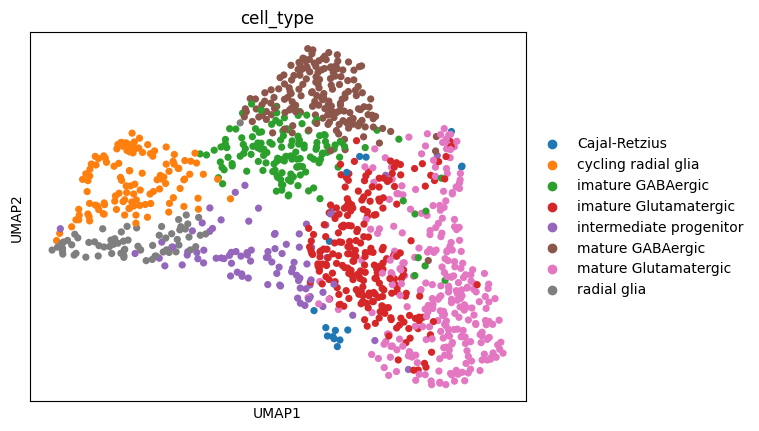

In [ ]:
import allos.visuals as vs
sc.pp.normalize_total(combined_mouse_data, target_sum=1e6)
sc.pp.log1p(combined_mouse_data)
sc.pp.neighbors(combined_mouse_data)
sc.tl.umap(combined_mouse_data)
sc.pl.umap(combined_mouse_data, color = 'cell_type')

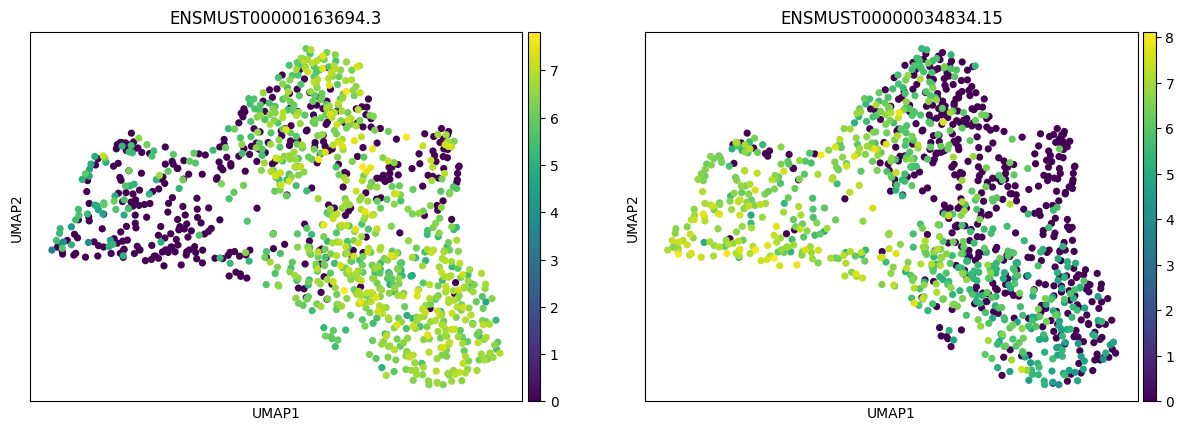

In [ ]:
vs.plot_transcripts(combined_mouse_data, gene_id='Pkm')

In [13]:
Pkm_Txs = combined_mouse_data[:, combined_mouse_data.var['geneId'] =='Pkm'].var.index.to_list()

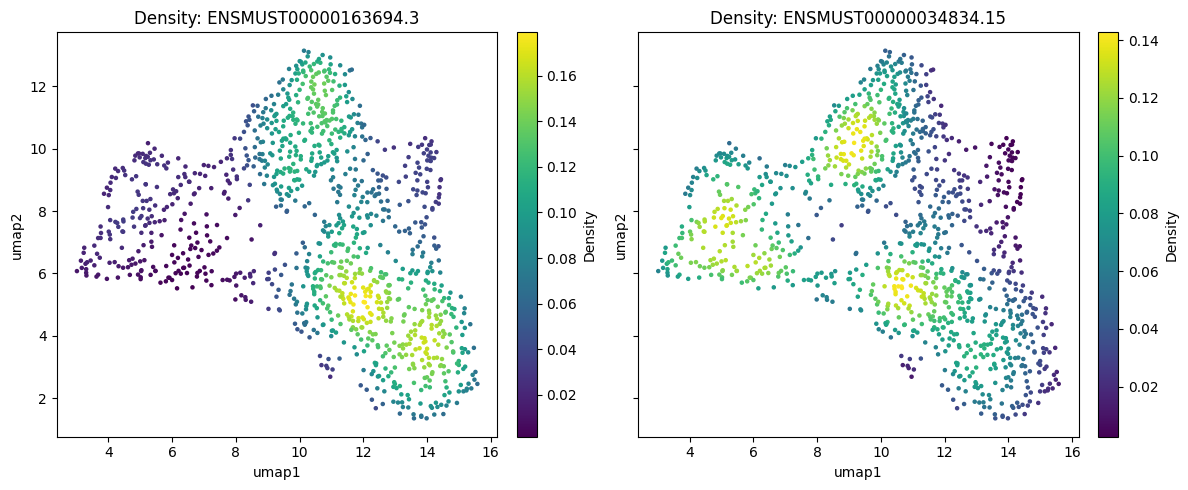

In [ ]:
vs.plot_density_multi(combined_mouse_data, features=Pkm_Txs)

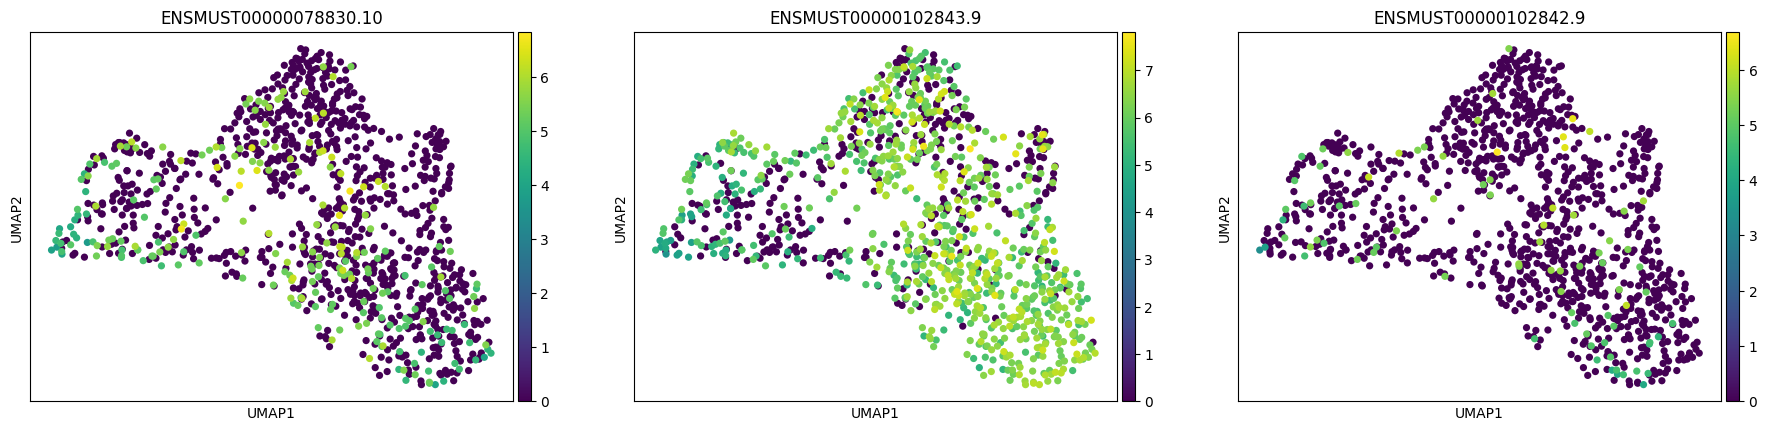

In [15]:
vs.plot_transcripts(combined_mouse_data, gene_id='Rtn4')

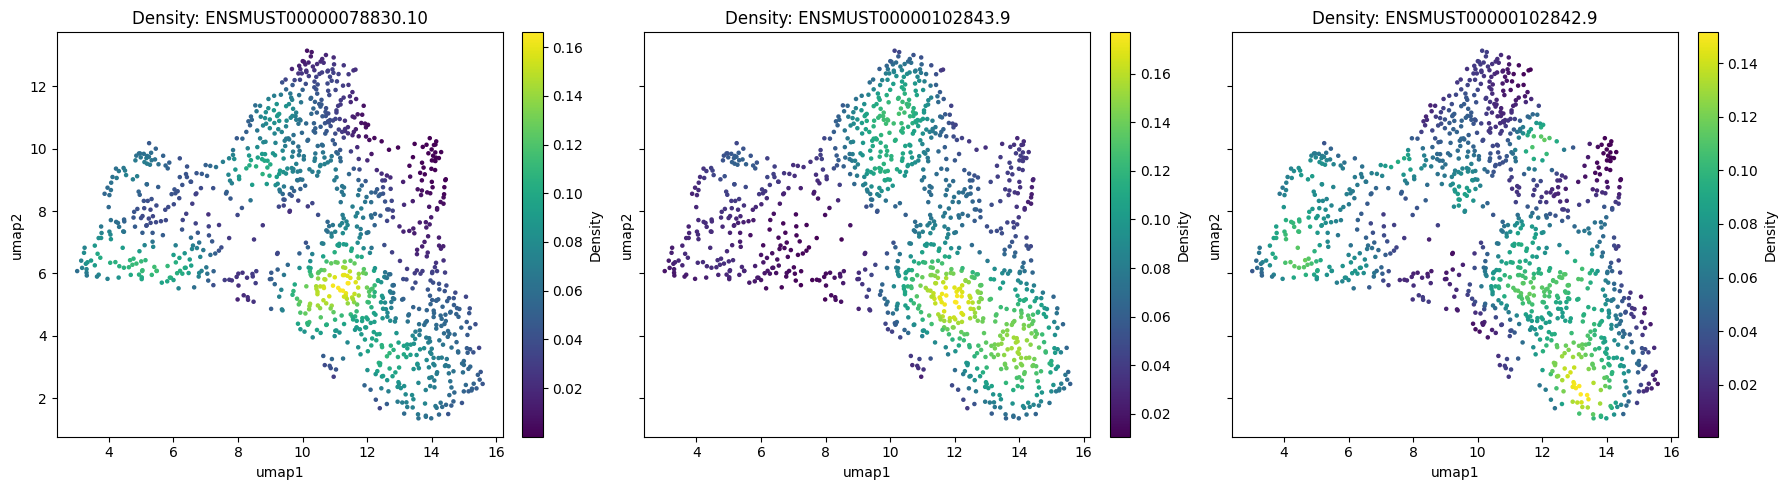

In [16]:
Eef1d_Txs = combined_mouse_data[:, combined_mouse_data.var['geneId'] =='Rtn4'].var.index.to_list()
vs.plot_density_multi(combined_mouse_data, features=Eef1d_Txs)

In [17]:
#| hide
from nbdev.showdoc import *

In [18]:
#| hide
import nbdev; nbdev.nbdev_export()